## U-net Architecture

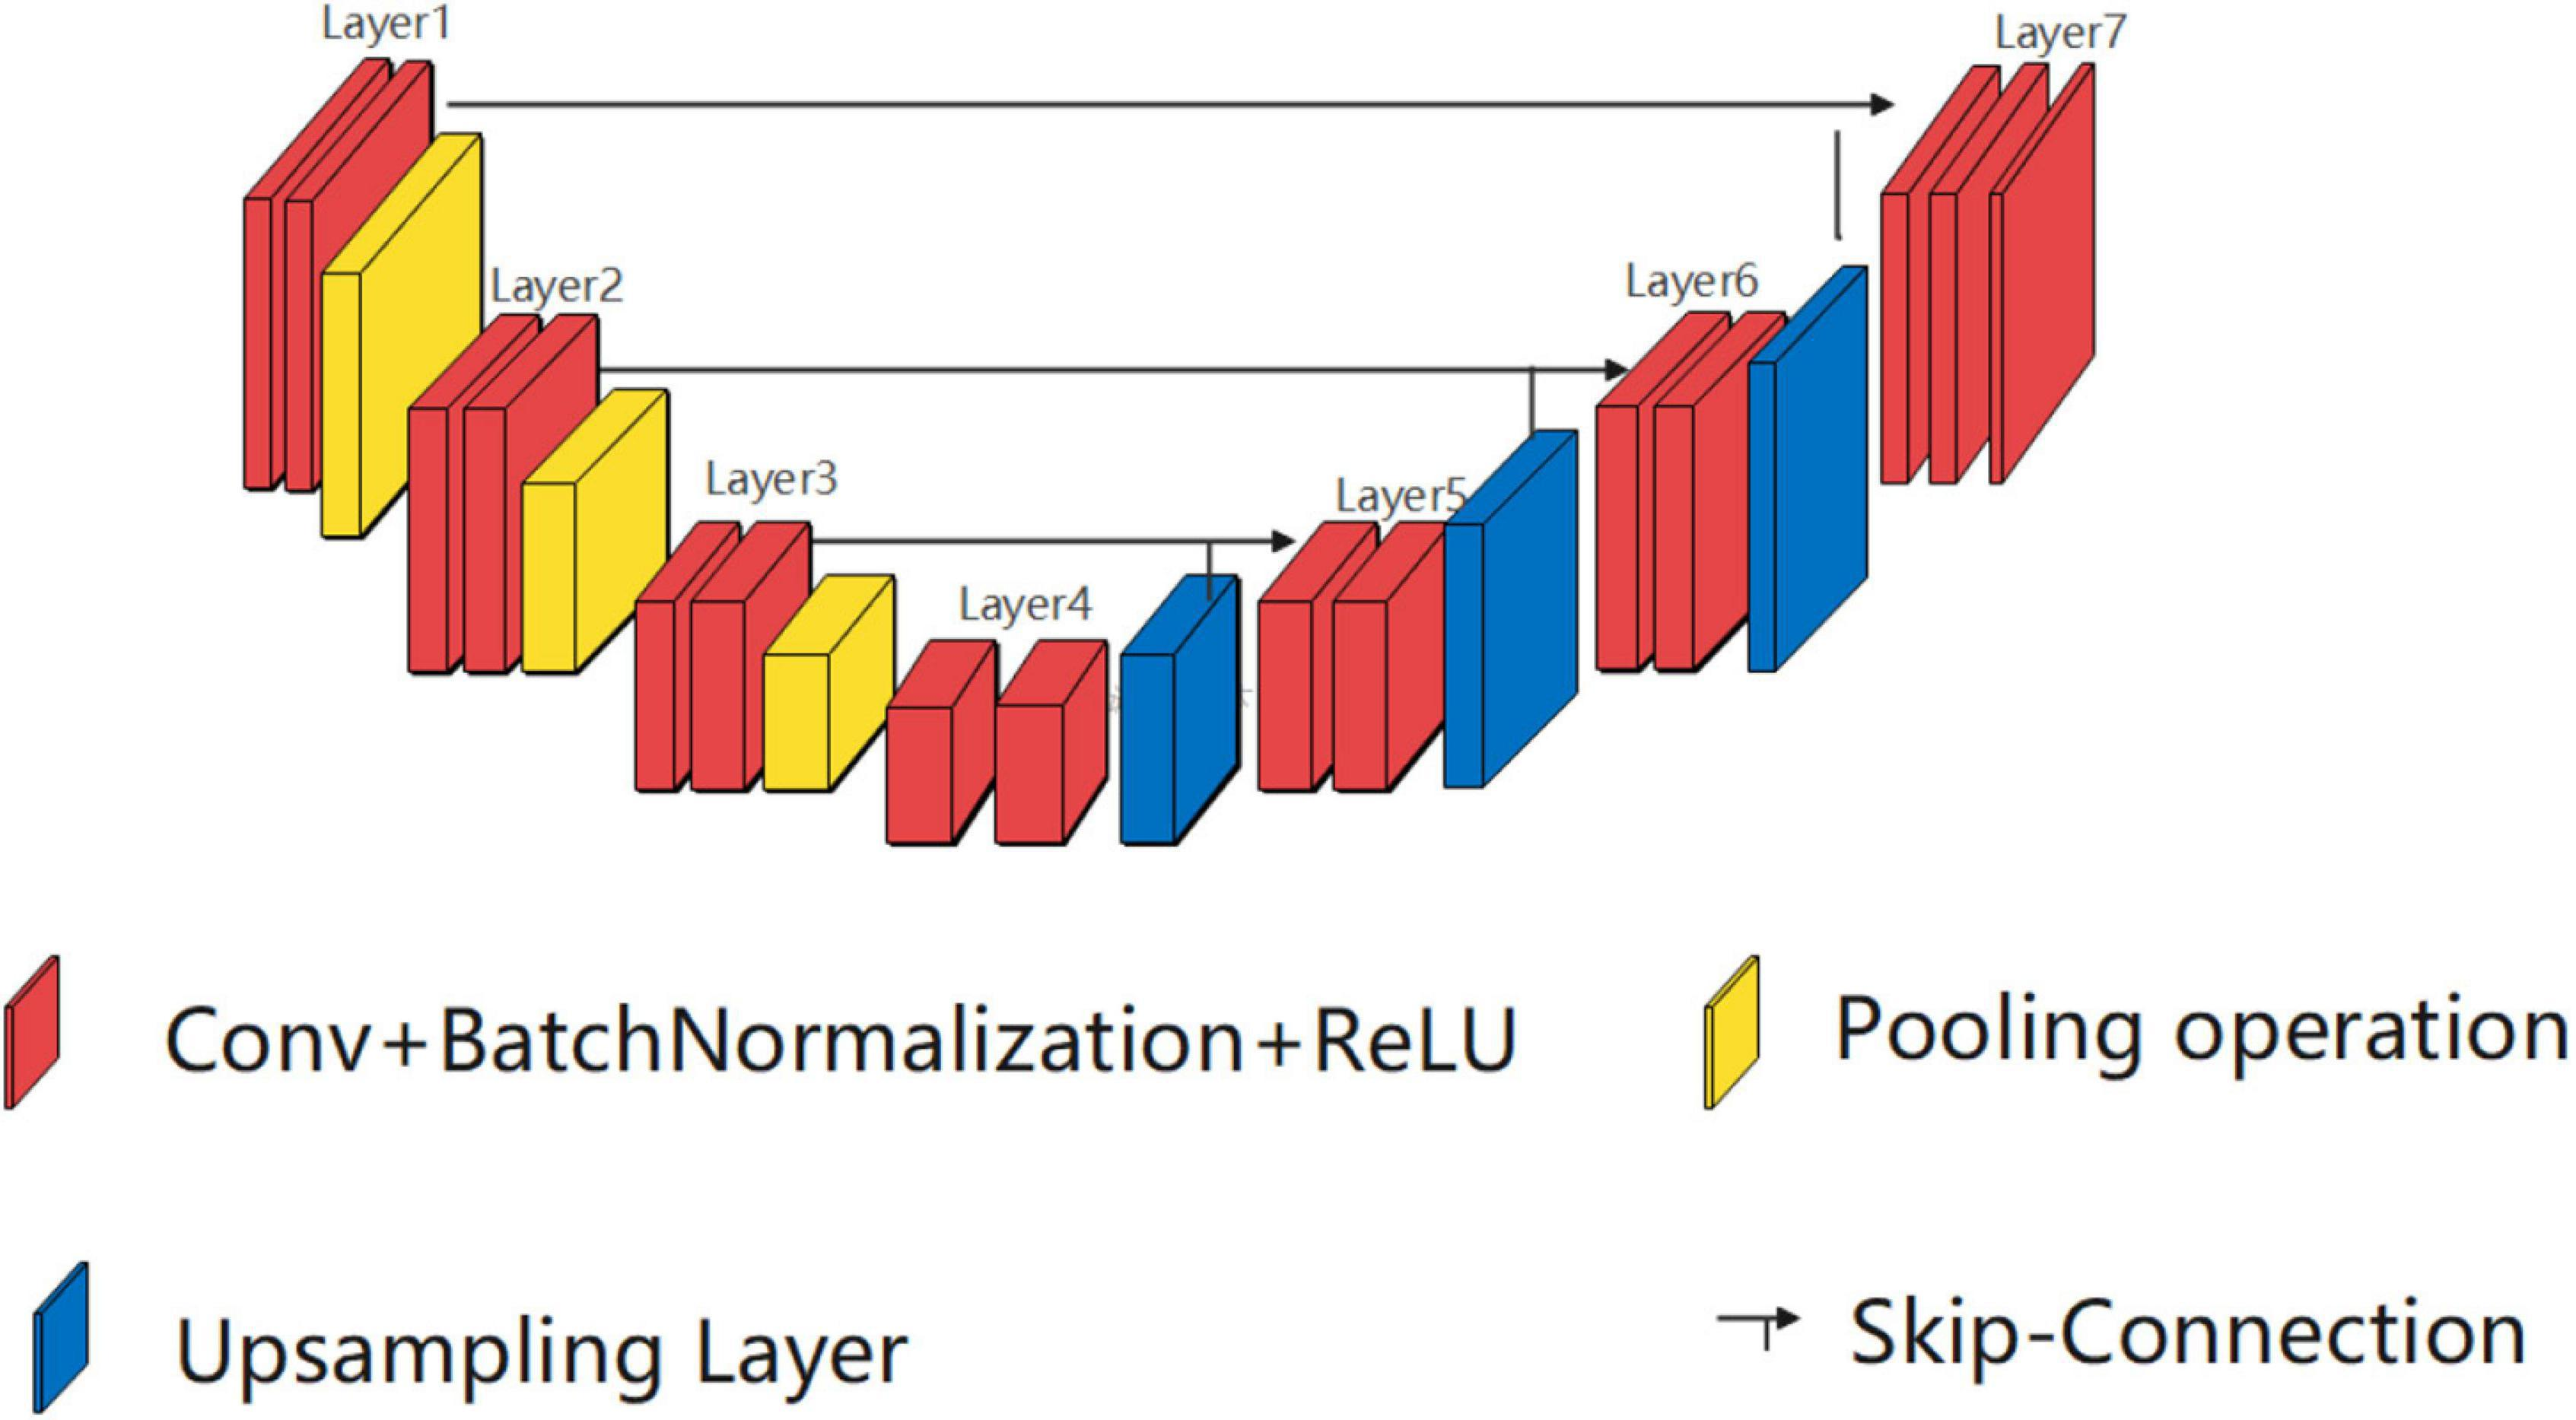

### Import Libraries

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

torch.cuda.is_available()

True

### Double Convolution block

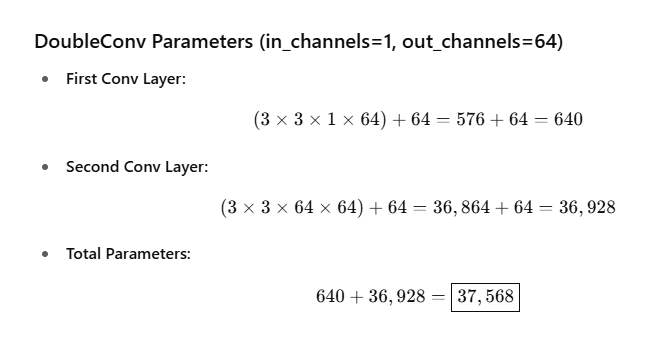

In [21]:
class DoubleConv(nn.Module): # nn.Module is parent class of the DoubleConv class
    """
    Applies two consecutive convolutional layers, each followed by ReLU.
    (Conv => ReLU) * 2
    """
        
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__() # Call the parent class constructor
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

### U-net Model

In [22]:
class UNet(nn.Module):
    """A simple U-Net architecture for image segmentation."""
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        """down path"""
        # layer 1
        down1 = self.down1(x)
        x = self.pool1(down1)

        # layer 2
        down2 = self.down2(x)
        x = self.pool2(down2)

        # layer 3
        down3 = self.down3(x)
        x = self.pool3(down3)

        # layer 4
        down4 = self.down4(x)
        x = self.pool4(down4)
        
        # bottleneck
        x = self.bottleneck(x)

        """up path"""
        # layer 4
        x = self.up4(x)
        x = torch.cat([x, down4], dim=1)
        x = self.up_conv4(x)

        # layer 3
        x = self.up3(x)
        x = torch.cat([x, down3], dim=1)
        x = self.up_conv3(x)

        # layer 2
        x = self.up2(x)
        x = torch.cat([x, down2], dim=1)
        x = self.up_conv2(x)

        # layer 1
        x = self.up1(x)
        x = torch.cat([x, down1], dim=1)
        x = self.up_conv1(x)

        # final output
        x = self.final_conv(x)
        return x

In [23]:
model = UNet(in_channels=1, out_channels=1)  # Binary segmentation

Test run on U-net model

torch.Size([1, 1, 256, 256])


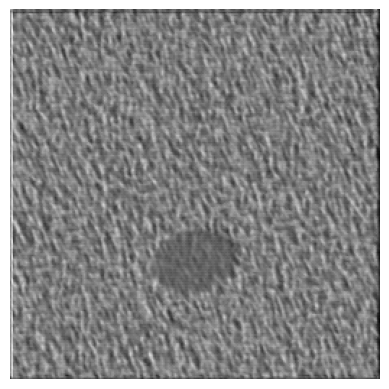

In [24]:
img = Image.open('dataset/images/image_000.png').convert('L').resize((256, 256))
img_tensor = torch.from_numpy(np.array(img, dtype=np.float32) / 255.0).unsqueeze(0).unsqueeze(0)
print(img_tensor.shape)

model.eval()  # Set the model to evaluation mode
if torch.cuda.is_available():
    model = model.cuda()
    img_tensor = img_tensor.cuda()
with torch.no_grad():
    output = model(img_tensor)
    
out = output.squeeze().detach().cpu().numpy()
out = (out - out.min()) / (out.max() - out.min())

# Visualize
plt.imshow(out, cmap='gray')
plt.axis('off')
plt.show()


### Load Dataset

Data augmentation

In [25]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

c:\Users\bimsa\.conda\envs\nlp\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Test run on augmentation

torch.Size([1, 256, 256])


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

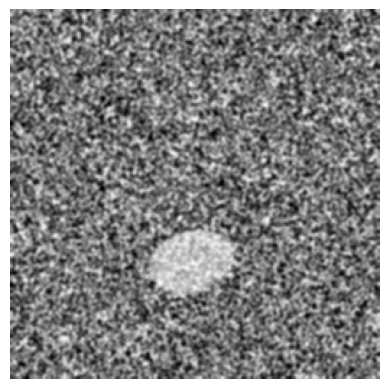

In [26]:
# run a test run and visualize the transformed image
transformed = transform(image=np.array(img))
print(transformed['image'].shape)
plt.imshow(transformed['image'].permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')

#### Data Loading

In [27]:
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    """Custom dataset for image segmentation tasks."""

    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = None


    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        if self.transform:
            transformed = self.transform(image=np.array(image), mask=np.array(mask))
            image = transformed['image']  # Already a FloatTensor with shape [C, H, W]
            mask = transformed['mask'].float().unsqueeze(0)  # Ensure float32 and shape [1, H, W]
        else:
            image = torch.from_numpy(np.array(image, dtype=np.float32) / 255.0).unsqueeze(0)  # [1, H, W]
            mask = torch.from_numpy(np.array(mask, dtype=np.float32) / 255.0).unsqueeze(0)    # [1, H, W]

        return image, mask

Check dataset object

In [28]:
# get all image and mask paths
import os
image_dir = 'dataset/images'
mask_dir = 'dataset/masks'
image_paths = [os.path.join(image_dir, f) for f in sorted(os.listdir(image_dir)) if f.endswith('.png')]
mask_paths = [os.path.join(mask_dir, f) for f in sorted(os.listdir(mask_dir)) if f.endswith('.png')]

# split into train and validation sets
from sklearn.model_selection import train_test_split
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

Preparing the Data with a DataLoader

In [29]:
from torch.utils.data import DataLoader

# Create the training dataset and dataloader
train_dataset = SegmentationDataset(
    image_paths=train_image_paths,
    mask_paths=train_mask_paths,
    transform=transform
)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Create the validation dataset and dataloader
val_dataset = SegmentationDataset(
    image_paths=val_image_paths,
    mask_paths=val_mask_paths,
    transform=transform
)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [30]:
# test the dataloaders
for images, masks in train_dataloader:
    print(f'Batch of images shape: {images.shape}')
    print(f'Batch of masks shape: {masks.shape}')
    break  # Just to test one batch

Batch of images shape: torch.Size([1, 1, 256, 256])
Batch of masks shape: torch.Size([1, 1, 256, 256])


The shape `[8, 256, 256]` for `mask` means you have a batch of 8 mask images, each with height and width of 256 pixels.  
- `8` is the batch size (number of samples in one batch from the DataLoader).
- `256, 256` are the spatial dimensions of each mask.

If you expected a channel dimension (e.g., `[8, 1, 256, 256]`), check your dataset's `__getitem__` method and your transforms to ensure masks are returned with a channel dimension, e.g., `mask.unsqueeze(0)` if needed.

### Define model, hyperparameters, optimizer and loss function

In [31]:
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import jaccard_score  # For IoU

In [32]:
# Hyperparameters
num_epochs = 5
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
model = UNet(in_channels=1, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy with Logits Loss for binary segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scaler = GradScaler()  # For mixed precision training

model

C:\Users\bimsa\AppData\Local\Temp\ipykernel_12220\582682534.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training


UNet(
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down3): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplac

- optimizer.zero_grad()      # ✅ clear old gradients
- output = model(data)
- loss = loss_fn(output, target)
- loss.backward()            # compute new gradients
- optimizer.step()           # update weights

In [ ]:
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    best_val_loss = float('inf')

    for images, masks in train_dataloader:
        # load image and ground truth mask to device
        image = images.to(device)
        mask = masks.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        with autocast():
            outputs = model(image)
            loss = criterion(outputs, mask)

        # backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_dataloader)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_loss = 0.0

        for val_batch in val_dataloader:
            val_images, val_masks = val_batch
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)

            with autocast():
                val_outputs = model(val_images)
                v_loss = criterion(val_outputs, val_masks).item()
            
            val_loss += v_loss

    avg_val_loss = val_loss / len(val_dataloader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'models/best_model.pth')

torch.save(model.state_dict(), 'models/last_model.pth')


C:\Users\bimsa\AppData\Local\Temp\ipykernel_12220\3632550290.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\bimsa\AppData\Local\Temp\ipykernel_12220\3632550290.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/5] | Train Loss: 0.0889 | Val Loss: 0.0113
Epoch [2/5] | Train Loss: 0.0225 | Val Loss: 0.0124
Epoch [3/5] | Train Loss: 0.0101 | Val Loss: 0.0110
Epoch [4/5] | Train Loss: 0.0103 | Val Loss: 0.0120
Epoch [5/5] | Train Loss: 0.0103 | Val Loss: 0.0088


### Do predictions on new data

In [37]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

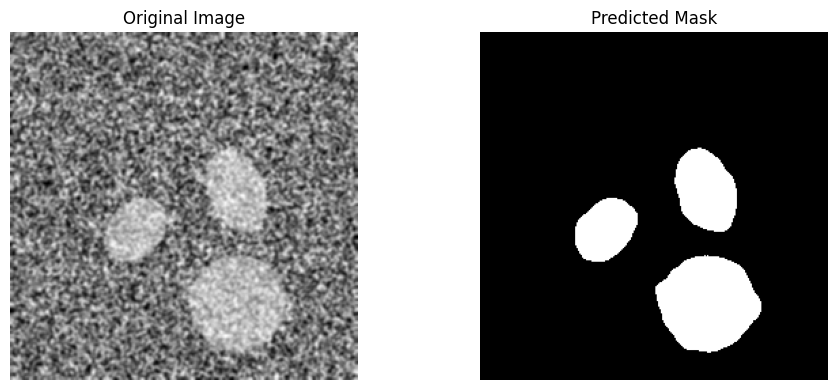

In [44]:
# --- Load your trained model ---
model.load_state_dict(torch.load('best_model.pth', map_location='cuda' if torch.cuda.is_available() else 'cpu'))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# --- Load and preprocess the image ---
img = Image.open('dataset/test_images/image_009.png').convert('L').resize((256, 256))  # Grayscale
img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize
img_tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0).to(device)  # Shape: [1, 1, H, W]

# --- Forward pass ---
with torch.no_grad():
    output = model(img_tensor)  # Shape: [1, 1, H, W]
    prob = torch.sigmoid(output)  # Apply sigmoid if model doesn’t already

# --- Convert to binary mask ---
binary_mask = (prob > 0.5).float().squeeze().cpu().numpy()  # Threshold

# --- Display Original Image and Prediction ---
plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Predicted mask
plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()